In [36]:
import json, os
import glob, pickle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel, ExpValCircuitGraphModel_2, ExpValCircuitGraphModel_3
from mlp import MLP1, MLP2, MLP3, encode_data
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from noise_utils import AddNoise, RemoveReadoutErrors

plt.style.use({'figure.facecolor':'white'})
D = {'output': 'mpl', 'fold': -1}

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [3]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = AddNoise(backend=backend).add_coherent_noise(seed=0, theta=np.pi * 0.04, uniform=False, add_depolarization=True)

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

random seed fixed to 0
thetas [0.06896594 0.08987335 0.07574548 0.06847204 0.05323803 0.08116545
 0.05498883 0.1120635 ]


In [37]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_no_readout = RemoveReadoutErrors().remove_readout_errors()[0]

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_no_readout = {'shots': 10000, 'backend': backend_noisy_no_readout, 'name': 'noisy_no_readout'}

num_qubit = 4

In [38]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [39]:
# model_path_1 = './model/ising_init_from_qasm/gnn1.pth'
# model_path_2 = './model/ising_init_from_qasm/mlp1_smaller.pth'
# model_path_3 = './model/ising_init_from_qasm/ols_full.pk'
# model_path_4 = './model/ising_init_from_qasm/ols.pk'
# model_path_5 = './model/ising_init_from_qasm/rfr_list.pk'

# model_path_1 = './model/ising_init_from_qasm_coherent/gnn1.pth'
# model_path_2 = './model/ising_init_from_qasm_coherent/mlp1_smaller.pth'
# model_path_3 = './model/ising_init_from_qasm_coherent/ols_full.pk'
# model_path_4 = './model/ising_init_from_qasm_coherent/ols.pk'
# model_path_5 = './model/ising_init_from_qasm_coherent/rfr_list.pk'

model_path_1 = './model/ising_init_from_qasm_no_readout/gnn1.pth'
model_path_2 = './model/ising_init_from_qasm_no_readout/mlp1_smaller.pth'
model_path_3 = './model/ising_init_from_qasm_no_readout/ols_full.pk'
model_path_5 = './model/ising_init_from_qasm_no_readout/rfr_list.pk'

# model_path_1 = './model/random_circuits/gnn1.pth'
# model_path_2 = './model/random_circuits/mlp1.pth'
# model_path_3 = './model/random_circuits/ols_full.pk'
# model_path_4 = './model/random_circuits/ols.pk'
# model_path_5 = './model/random_circuits/rfr_list.pk'

In [40]:
models = []

model_1 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_1.load_state_dict(torch.load(model_path_1), strict=True)
model_1.eval()
models.append((model_1, 'gnn'))

model_2 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=64
)
model_2.load_state_dict(torch.load(model_path_2), strict=True)
model_2.eval()
models.append((model_2, 'mlp'))

with open(model_path_3, 'rb') as f:
    model_3 = pickle.load(f)
models.append((model_3, 'ols_full'))

# with open(model_path_4, 'rb') as f:
#     model_4 = pickle.load(f)
# models.append((model_4, 'ols'))

with open(model_path_5, 'rb') as f:
    model_5 = pickle.load(f)
models.append((model_5, 'rfr_list'))

models.append((None, 'zne'))

In [41]:
import re
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    steps = []
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            step = int(re.search(r'\d+', data_file.split('/')[-1]).group())
            for entry in pickle.load(open(data_file, 'rb')):
                steps.append(step)
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals, steps

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps = load_circuits('./data/ising_init_from_qasm_no_readout/val_extra/', '.pk')
# test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps = load_circuits('./data/ising_init_from_qasm/val_Zonly/', '.pk')
print(len(test_circuits))
# test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps = load_circuits('./data/haoran_mbd/random_circuits/val/', '.pk')
# print(len(test_circuits))

test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]

  0%|          | 0/23 [00:00<?, ?it/s]

6900


In [12]:
# with open('./zne_mitigated/ising_init_from_qasm_extra_degree2.pk', 'rb') as file:
#     zne_mitigated = pickle.load(file)[:4500]
# print(len(zne_mitigated))

4500


In [49]:
with open('./zne_mitigated/ising_init_from_qasm_no_readout_extra_degree2.pk', 'rb') as file:
    zne_mitigated = pickle.load(file)
print(len(zne_mitigated))

4500


In [50]:
to_df = []

for i, (circ, ideal_exp_val, noisy_exp_val, zne_val, step) in tqdm(enumerate(zip(test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, zne_mitigated, steps)), total=len(test_circuits)):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val
    row['step'] = step

    circ_trans = transpile(circ, backend, optimization_level=3)
    graph_data = circuit_to_graph_data_json(
                circuit=circ_trans,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

    try:
        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val,
            noisy_exp_values=[noisy_exp_val],
            circuit_depth=circ_trans.depth()
        ).to_pyg_data()
    except KeyError as e:
        print(f'Run into: {e}')
        continue

    X, _ = encode_data([circ_trans], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name] = model(X).tolist()[0]
        elif name == 'gnn':
            row[name] = model(entry.noisy_0,
                                    entry.observable,
                                    entry.circuit_depth,
                                    entry.x,
                                    entry.edge_index,
                                    entry.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name] = model.predict(X).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name] = model.predict(X[:, -4:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_val
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/6900 [00:00<?, ?it/s]

In [51]:
df = pd.DataFrame(to_df)
def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

In [52]:
df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_61137/2850071208.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('step').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_61137/2850071208.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))


KeyError: 'L2_gnn'

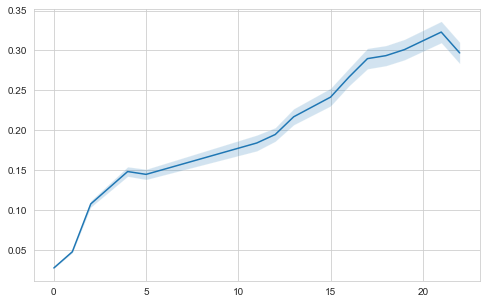

In [53]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
xs = sorted(set(df.step))
legend_labels = ['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated']
for i, col in enumerate(['L2_noisy', 'L2_gnn', 'L2_mlp', 'L2_rfr_list', 'L2_ols_full', 'L2_zne']):
# legend_labels = ['Unmitigated', 'RF Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_rfr_list']):
    plt.plot(xs, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=xs, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
# plt.ylim([0, 0.64])
plt.xlim([0, 29])
# plt.vlines(x=14, ymin=0, ymax=1, color='gray', label='Train data availability')
plt.legend()
plt.grid(None)
plt.show()

In [ ]:
models = []
with open(model_path_3, 'rb') as f:
    model_3 = pickle.load(f)
models.append((model_3, 'ols_full'))

to_df = []

for i, (circ, ideal_exp_val, noisy_exp_val, step) in tqdm(
        enumerate(zip(test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps)),
        total=len(test_circuits)):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val
    row['step'] = step

    circ_trans = transpile(circ, backend, optimization_level=0)
    # graph_data = circuit_to_graph_data_json(
    #     circuit=circ_trans,
    #     properties=properties,
    #     use_qubit_features=True,
    #     use_gate_features=True,
    # )
    #
    # try:
    #     entry = ExpValueEntry(
    #         circuit_graph=graph_data,
    #         observable=[],
    #         ideal_exp_value=ideal_exp_val,
    #         noisy_exp_values=[noisy_exp_val],
    #         circuit_depth=circ_trans.depth()
    #     ).to_pyg_data()
    # except KeyError as e:
    #     print(f'Run into: {e}')
    #     continue

    X, _ = encode_data([circ_trans], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name] = model(X).tolist()[0]
        elif name == 'gnn':
            row[name] = model(entry.noisy_0,
                              entry.observable,
                              entry.circuit_depth,
                              entry.x,
                              entry.edge_index,
                              entry.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name] = model.predict(X).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name] = model.predict(X[:, -4:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_mitigated
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)
df = pd.DataFrame(to_df)

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b) ** 2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)
df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step'] == 0]))
plt.style.use({'figure.facecolor': 'white'})
plt.figure(figsize=(8, 5))
xs = sorted(set(df.step))
# legend_labels = ['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_gnn', 'L2_mlp', 'L2_rfr_list', 'L2_ols_full', 'L2_zne']):
legend_labels = ['Unmitigated', 'OLS']
for i, col in enumerate(['L2_noisy', 'L2_ols_full']):
    plt.plot(xs, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=xs, y1=df_mean[col] - df_ste[col], y2=df_mean[col] + df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
# plt.ylim([0, 0.64])
plt.xlim([0, 29])
# plt.vlines(x=14, ymin=0, ymax=1, color='gray', label='Train data availability')
plt.legend()
plt.grid(None)
plt.show()

In [14]:
# to_dump = {
#     'df': df,
#     'df_mean': df_mean,
#     'df_ste': df_ste,
# }
# with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/coherent_over_depths.pk', 'wb') as file:
#     pickle.dump(to_dump, file)

In [ ]:
# df_hue = []
# for i in range(len(df)):
#     for col in ['RMSE_noisy', 'RMSE_rfr_list', 'RMSE_zne']:
#         df_hue.append([df.loc[i, 'step'], df.loc[i, col], col])
# df_hue = pd.DataFrame(df_hue)
# df_hue.columns = ['step', 'RMSE', 'name']
#
# plt.figure(figsize=(15, 5))
# plt.style.use({'figure.facecolor':'white'})
# g = sns.boxplot(data=df_hue, x='step', y='RMSE', hue='name')
# g.legend(title="")
# new_legend_labels = ['Unmitigated', 'Mitigated by RF', 'Mitigated by ZNE']
# for i in range(3):
#     g.legend_.texts[i].set_text(new_legend_labels[i])
# plt.xlabel('Trotter Steps')
# plt.ylabel('RMSE from Ideal Expectation Values')
# plt.show()

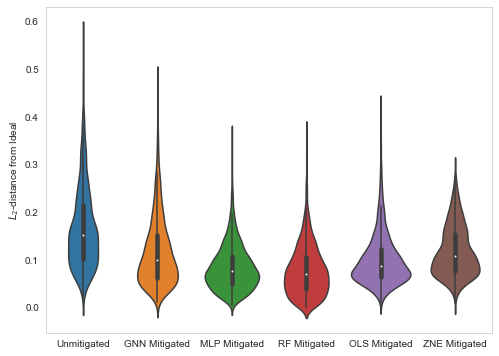

In [21]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df[['L2_noisy', 'L2_gnn', 'L2_mlp', 'L2_rfr_list', 'L2_ols_full', 'L2_zne']])
# labels = ax.get_xticklabels()
ax.set_xticklabels(['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated'])
plt.ylabel(r'$L_2$-distance from Ideal')
# plt.ylim([-0.003, 0.02])
ax.grid(False)
plt.show()

In [23]:
# to_dump = {
#     'df': df,
# }
# with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/random_circuits.pk', 'wb') as file:
#     pickle.dump(to_dump, file)